In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Folders and Files

In [2]:
model_1_name = "Mul8"
model_2_name = "Ori"

In [3]:
output_full_build_folder_1 = ('./experiments' 
                      + '/750_FPS_mul8_scale_fixed'
                      + '/03_full_build_mvau_rtl_hls_padding_rtl'
                      + '/output_full_build')
experiments_folder_1 = output_full_build_folder_1 + '/report/post_synth_resources.json'
final_hw_file_1 = output_full_build_folder_1 + '/final_hw_config.json'

output_full_build_folder_2 = ('../my_mblnet_resnet_to_finn_driver/experiments/' 
                      + '/750_FPS'
                      + '/02_full_build_vvau_lut_hls_mvau_hls'
                      + '/output_full_build')
experiments_folder_2 = output_full_build_folder_2 + '/report/post_synth_resources.json'
final_hw_file_2 = output_full_build_folder_2 + '/final_hw_config.json'

# JSON to Dict

In [4]:
# POST-SYNTH Resources
with open(experiments_folder_1, 'r') as post_synth_json_file_1:
    post_synth_1 = json.load(post_synth_json_file_1)

with open(experiments_folder_2, 'r') as post_synth_json_file_2:
    post_synth_2 = json.load(post_synth_json_file_2)

# FIFOs
with open(final_hw_file_1, 'r') as final_hw_json_file_1:
    final_hw_1 = json.load(final_hw_json_file_1)

with open(final_hw_file_2, 'r') as final_hw_json_file_2:
    final_hw_2 = json.load(final_hw_json_file_2)

# Estimate Resources

## LUT

### LUT Top

In [5]:
lut_top_1 = {k: v['LUT'] for k, v in post_synth_1.items() if k == "(top)"}
lut_top_2 = {k: v['LUT'] for k, v in post_synth_2.items() if k == "(top)"}

print(f'LUT TOP {model_1_name}: {lut_top_1}')
print(f'LUT TOP {model_2_name}: {lut_top_2}')

LUT TOP Mul8: {'(top)': 43191}
LUT TOP Ori: {'(top)': 40034}


### LUT Layer

In [6]:
lut_1 = {k: v['LUT'] for k, v in post_synth_1.items() if k != "(top)"}
lut_2 = {k: v['LUT'] for k, v in post_synth_2.items() if k != "(top)"}
lut_total_1 = list(lut_1.values())
lut_total_2 = list(lut_2.values())

print(f'LUT {model_1_name}: {sum(lut_total_1)}')
print(f'LUT {model_2_name}: {sum(lut_total_2)}')

LUT Mul8: 38865
LUT Ori: 35673


### LUT per Layer Type

In [7]:
layer_types = [
    "DMA", 
    "FIFO", 
    "Thresholding", 
    "Padding",
    "ConvolutionInputGenerator",
    "StreamingDataWidthConverter",
    "MVAU",
    "VVAU",
    "DuplicateStreams",
    "AddStreams",
    "Pool"
]

luts_per_layer_type_1 = {k: 0 for k in layer_types}
for k, v in post_synth_1.items():
    if k == "(top)":
        print("Top skipped")
    else:
        layer_present = False
        for layer_type in layer_types:
            if layer_type in k:
                layer_present = True
                luts_per_layer_type_1[layer_type] += v["LUT"]
        assert layer_present == True, f'{k} is not present in layer types'

luts_per_layer_type_2 = {k: 0 for k in layer_types}
for k, v in post_synth_2.items():
    if k == "(top)":
        print("Top skipped")
    else:
        layer_present = False
        for layer_type in layer_types:
            if layer_type in k:
                layer_present = True
                luts_per_layer_type_2[layer_type] += v["LUT"]
        assert layer_present == True, f'{k} is not present in layer types'

for (k1, v1), (k2, v2) in zip(luts_per_layer_type_1.items(), luts_per_layer_type_2.items()):
    print(f'{model_1_name}: {k1:<30} = {v1:<6} - {model_2_name}: {k2:<30} = {v2:<6}')

print(f'\nTotal {model_1_name}: {sum(luts_per_layer_type_1.values())}')
print(f'Total {model_2_name}: {sum(luts_per_layer_type_2.values())}')
print(f'Diference {model_1_name}-{model_2_name}: {sum(luts_per_layer_type_1.values()) - sum(luts_per_layer_type_2.values())}')

Top skipped
Top skipped
Mul8: DMA                            = 2759   - Ori: DMA                            = 2764  
Mul8: FIFO                           = 17973  - Ori: FIFO                           = 9186  
Mul8: Thresholding                   = 2831   - Ori: Thresholding                   = 6245  
Mul8: Padding                        = 1374   - Ori: Padding                        = 1031  
Mul8: ConvolutionInputGenerator      = 2252   - Ori: ConvolutionInputGenerator      = 2257  
Mul8: StreamingDataWidthConverter    = 1833   - Ori: StreamingDataWidthConverter    = 743   
Mul8: MVAU                           = 5454   - Ori: MVAU                           = 9056  
Mul8: VVAU                           = 3734   - Ori: VVAU                           = 3735  
Mul8: DuplicateStreams               = 249    - Ori: DuplicateStreams               = 246   
Mul8: AddStreams                     = 291    - Ori: AddStreams                     = 292   
Mul8: Pool                           = 115    

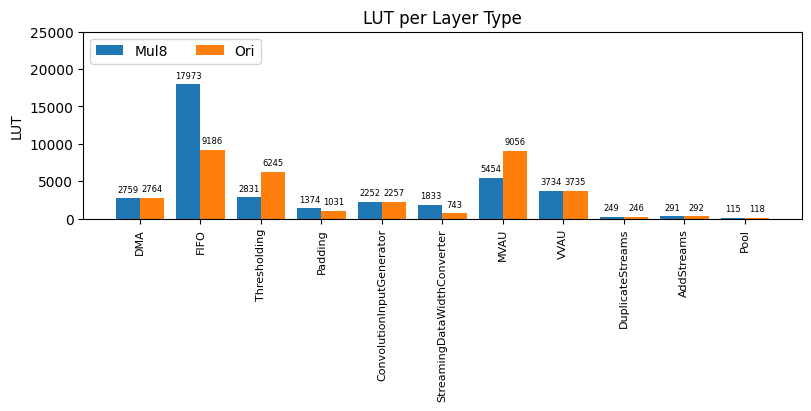

In [8]:
luts_per_layer_type_models = {
    model_1_name: list(luts_per_layer_type_1.values()),
    model_2_name: list(luts_per_layer_type_2.values())
}

x = np.arange(len(luts_per_layer_type_1.keys()))  # the label locations
width = 0.4  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(8, 4))

for attribute, measurement in luts_per_layer_type_models.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3, fontsize = 6)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('LUT')
ax.set_title('LUT per Layer Type')
ax.set_xticks(x + width/2, luts_per_layer_type_1.keys(), rotation=90, fontsize = 8)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 25000)

plt.show()

## DSP

### DSP Top

In [9]:
dsp_top_1 = {k: v['DSP'] for k, v in post_synth_1.items() if k == "(top)"}
dsp_top_2 = {k: v['DSP'] for k, v in post_synth_2.items() if k == "(top)"}

print(f'DSP TOP {model_1_name}: {dsp_top_1}')
print(f'DSP TOP {model_2_name}: {dsp_top_2}')

DSP TOP Mul8: {'(top)': 216}
DSP TOP Ori: {'(top)': 212}


### DSP Layer

In [10]:
dsp_1 = {k: v['DSP'] for k, v in post_synth_1.items() if k != "(top)"}
dsp_2 = {k: v['DSP'] for k, v in post_synth_2.items() if k != "(top)"}
dsp_total_1 = list(dsp_1.values())
dsp_total_2 = list(dsp_2.values())

print(f'DSP {model_1_name}: {sum(dsp_total_1)}')
print(f'DSP {model_2_name}: {sum(dsp_total_2)}')

DSP Mul8: 216
DSP Ori: 212


### DSP per Layer Type

In [11]:
dsp_per_layer_type_1 = {k: 0 for k in layer_types}
for k, v in post_synth_1.items():
    if k == "(top)":
        print("Top skipped")
    else:
        layer_present = False
        for layer_type in layer_types:
            if layer_type in k:
                layer_present = True
                dsp_per_layer_type_1[layer_type] += v["DSP"]
        assert layer_present == True, f'{k} is not present in layer types'

dsp_per_layer_type_2 = {k: 0 for k in layer_types}
for k, v in post_synth_2.items():
    if k == "(top)":
        print("Top skipped")
    else:
        layer_present = False
        for layer_type in layer_types:
            if layer_type in k:
                layer_present = True
                dsp_per_layer_type_2[layer_type] += v["DSP"]
        assert layer_present == True, f'{k} is not present in layer types'

for (k1, v1), (k2, v2) in zip(dsp_per_layer_type_1.items(), dsp_per_layer_type_2.items()):
    print(f'{model_1_name}: {k1:<30} = {v1:<6} - {model_2_name}: {k2:<30} = {v2:<6}')

print(f'\nTotal {model_1_name}: {sum(dsp_per_layer_type_1.values())}')
print(f'Total {model_2_name}: {sum(dsp_per_layer_type_2.values())}')
print(f'Diference {model_1_name}-{model_2_name}: {sum(dsp_per_layer_type_1.values()) - sum(dsp_per_layer_type_2.values())}')

Top skipped
Top skipped
Mul8: DMA                            = 0      - Ori: DMA                            = 0     
Mul8: FIFO                           = 0      - Ori: FIFO                           = 0     
Mul8: Thresholding                   = 0      - Ori: Thresholding                   = 0     
Mul8: Padding                        = 0      - Ori: Padding                        = 0     
Mul8: ConvolutionInputGenerator      = 0      - Ori: ConvolutionInputGenerator      = 0     
Mul8: StreamingDataWidthConverter    = 0      - Ori: StreamingDataWidthConverter    = 0     
Mul8: MVAU                           = 216    - Ori: MVAU                           = 212   
Mul8: VVAU                           = 0      - Ori: VVAU                           = 0     
Mul8: DuplicateStreams               = 0      - Ori: DuplicateStreams               = 0     
Mul8: AddStreams                     = 0      - Ori: AddStreams                     = 0     
Mul8: Pool                           = 0      

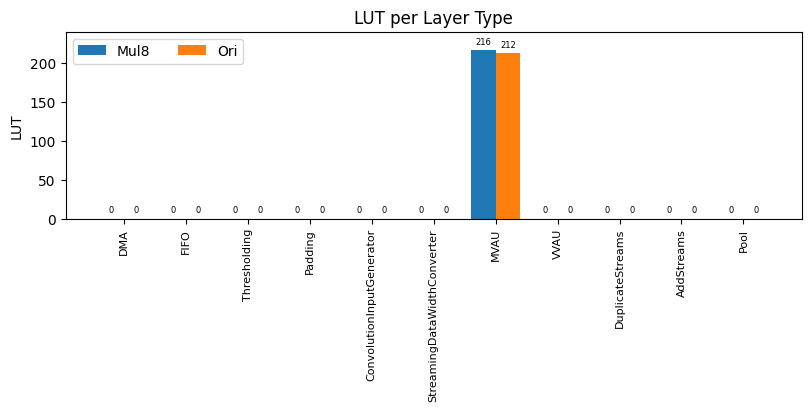

In [12]:
dsp_per_layer_type_models = {
    model_1_name: list(dsp_per_layer_type_1.values()),
    model_2_name: list(dsp_per_layer_type_2.values())
}

x = np.arange(len(dsp_per_layer_type_1.keys()))  # the label locations
width = 0.4  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(8, 4))

for attribute, measurement in dsp_per_layer_type_models.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3, fontsize = 6)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('LUT')
ax.set_title('LUT per Layer Type')
ax.set_xticks(x + width/2, dsp_per_layer_type_1.keys(), rotation=90, fontsize = 8)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 240)

plt.show()

## BRAM

### BRAM 18K Top

In [13]:
bram_18_top_1 = {k: v['BRAM_18K'] for k, v in post_synth_1.items() if k == "(top)"}
bram_18_top_2 = {k: v['BRAM_18K'] for k, v in post_synth_2.items() if k == "(top)"}

print(f'BRAM 18K TOP {model_1_name}: {bram_18_top_1}')
print(f'BRAM 18K TOP {model_2_name}: {bram_18_top_2}')

BRAM 18K TOP Mul8: {'(top)': 129}
BRAM 18K TOP Ori: {'(top)': 92}


### BRAM 18K Layer

In [14]:
bram_18_1 = {k: v['BRAM_18K'] for k, v in post_synth_1.items() if k != "(top)"}
bram_18_2 = {k: v['BRAM_18K'] for k, v in post_synth_2.items() if k != "(top)"}
bram_18_total_1 = list(bram_18_1.values())
bram_18_total_2 = list(bram_18_2.values())

In [15]:
print(f'BRAM 18K {model_1_name}: {sum(bram_18_total_1)}')
print(f'BRAM 18K {model_2_name}: {sum(bram_18_total_2)}')

BRAM 18K Mul8: 129
BRAM 18K Ori: 92


### BRAM 18K per Layer Type

In [16]:
bram_18_per_layer_type_1 = {k: 0 for k in layer_types}
for k, v in post_synth_1.items():
    if k == "(top)":
        print("Top skipped")
    else:
        layer_present = False
        for layer_type in layer_types:
            if layer_type in k:
                layer_present = True
                bram_18_per_layer_type_1[layer_type] += v["BRAM_18K"]
        assert layer_present == True, f'{k} is not present in layer types'

bram_18_per_layer_type_2 = {k: 0 for k in layer_types}
for k, v in post_synth_2.items():
    if k == "(top)":
        print("Top skipped")
    else:
        layer_present = False
        for layer_type in layer_types:
            if layer_type in k:
                layer_present = True
                bram_18_per_layer_type_2[layer_type] += v["BRAM_18K"]
        assert layer_present == True, f'{k} is not present in layer types'

for (k1, v1), (k2, v2) in zip(bram_18_per_layer_type_1.items(), bram_18_per_layer_type_2.items()):
    print(f'{model_1_name}: {k1:<30} = {v1:<6} - {model_2_name}: {k2:<30} = {v2:<6}')

Top skipped
Top skipped
Mul8: DMA                            = 1      - Ori: DMA                            = 1     
Mul8: FIFO                           = 15     - Ori: FIFO                           = 23    
Mul8: Thresholding                   = 82     - Ori: Thresholding                   = 43    
Mul8: Padding                        = 0      - Ori: Padding                        = 0     
Mul8: ConvolutionInputGenerator      = 6      - Ori: ConvolutionInputGenerator      = 3     
Mul8: StreamingDataWidthConverter    = 0      - Ori: StreamingDataWidthConverter    = 0     
Mul8: MVAU                           = 16     - Ori: MVAU                           = 13    
Mul8: VVAU                           = 9      - Ori: VVAU                           = 9     
Mul8: DuplicateStreams               = 0      - Ori: DuplicateStreams               = 0     
Mul8: AddStreams                     = 0      - Ori: AddStreams                     = 0     
Mul8: Pool                           = 0      

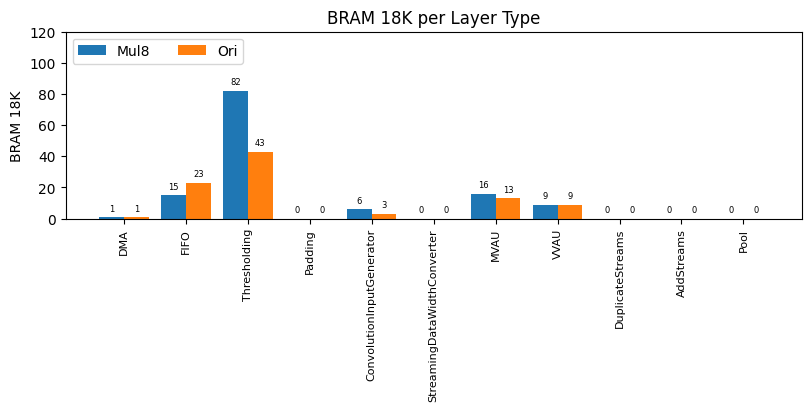

In [17]:
bram_18_per_layer_type_models = {
    model_1_name: list(bram_18_per_layer_type_1.values()),
    model_2_name: list(bram_18_per_layer_type_2.values())
}

x = np.arange(len(bram_18_per_layer_type_1.keys()))  # the label locations
width = 0.4  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(8, 4))

for attribute, measurement in bram_18_per_layer_type_models.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3, fontsize = 6)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('BRAM 18K')
ax.set_title('BRAM 18K per Layer Type')
ax.set_xticks(x + width/2, bram_18_per_layer_type_1.keys(), rotation=90, fontsize = 8)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 120)

plt.show()

### BRAM 36K Top

In [18]:
bram_36_top_1 = {k: v['BRAM_36K'] for k, v in post_synth_1.items() if k == "(top)"}
bram_36_top_2 = {k: v['BRAM_36K'] for k, v in post_synth_2.items() if k == "(top)"}

print(f'BRAM 36K TOP {model_1_name}: {bram_36_top_1}')
print(f'BRAM 36K TOP {model_2_name}: {bram_36_top_2}')

BRAM 36K TOP Mul8: {'(top)': 65}
BRAM 36K TOP Ori: {'(top)': 79}


### BRAM 36K Layer

In [19]:
bram_36_1 = {k: v['BRAM_36K'] for k, v in post_synth_1.items() if k != "(top)"}
bram_36_2 = {k: v['BRAM_36K'] for k, v in post_synth_2.items() if k != "(top)"}
bram_36_total_1 = list(bram_36_1.values())
bram_36_total_2 = list(bram_36_2.values())

In [20]:
print(f'BRAM 36K {model_1_name}: {sum(bram_36_total_1)}')
print(f'BRAM 36K {model_2_name}: {sum(bram_36_total_2)}')

BRAM 36K Mul8: 65
BRAM 36K Ori: 79


### BRAM 36K per Layer Type

In [21]:
bram_36_per_layer_type_1 = {k: 0 for k in layer_types}
for k, v in post_synth_1.items():
    if k == "(top)":
        print("Top skipped")
    else:
        layer_present = False
        for layer_type in layer_types:
            if layer_type in k:
                layer_present = True
                bram_36_per_layer_type_1[layer_type] += v["BRAM_36K"]
        assert layer_present == True, f'{k} is not present in layer types'

bram_36_per_layer_type_2 = {k: 0 for k in layer_types}
for k, v in post_synth_2.items():
    if k == "(top)":
        print("Top skipped")
    else:
        layer_present = False
        for layer_type in layer_types:
            if layer_type in k:
                layer_present = True
                bram_36_per_layer_type_2[layer_type] += v["BRAM_36K"]
        assert layer_present == True, f'{k} is not present in layer types'

for (k1, v1), (k2, v2) in zip(bram_36_per_layer_type_1.items(), bram_36_per_layer_type_2.items()):
    print(f'{model_1_name}: {k1:<30} = {v1:<6} - {model_2_name}: {k2:<30} = {v2:<6}')

Top skipped
Top skipped
Mul8: DMA                            = 1      - Ori: DMA                            = 1     
Mul8: FIFO                           = 42     - Ori: FIFO                           = 41    
Mul8: Thresholding                   = 0      - Ori: Thresholding                   = 7     
Mul8: Padding                        = 0      - Ori: Padding                        = 0     
Mul8: ConvolutionInputGenerator      = 8      - Ori: ConvolutionInputGenerator      = 13    
Mul8: StreamingDataWidthConverter    = 0      - Ori: StreamingDataWidthConverter    = 0     
Mul8: MVAU                           = 12     - Ori: MVAU                           = 15    
Mul8: VVAU                           = 2      - Ori: VVAU                           = 2     
Mul8: DuplicateStreams               = 0      - Ori: DuplicateStreams               = 0     
Mul8: AddStreams                     = 0      - Ori: AddStreams                     = 0     
Mul8: Pool                           = 0      

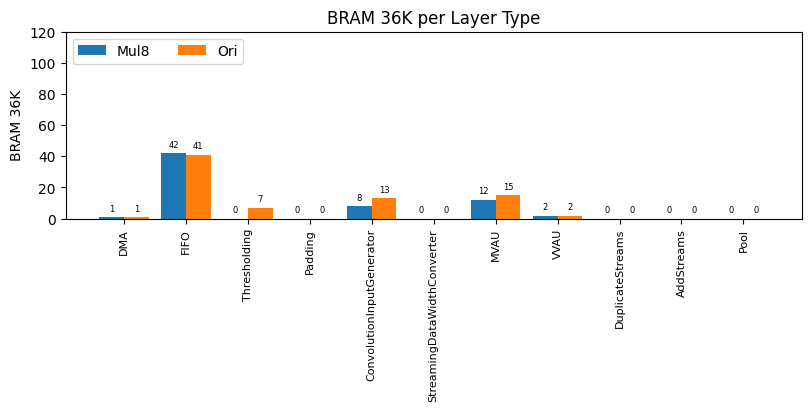

In [22]:
bram_36_per_layer_type_models = {
    model_1_name: list(bram_36_per_layer_type_1.values()),
    model_2_name: list(bram_36_per_layer_type_2.values())
}

x = np.arange(len(bram_36_per_layer_type_1.keys()))  # the label locations
width = 0.4  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(8, 4))

for attribute, measurement in bram_36_per_layer_type_models.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3, fontsize = 6)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('BRAM 36K')
ax.set_title('BRAM 36K per Layer Type')
ax.set_xticks(x + width/2, bram_36_per_layer_type_1.keys(), rotation=90, fontsize = 8)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 120)

plt.show()

## FF

### FF Top

In [23]:
ff_top_1 = {k: v['FF'] for k, v in post_synth_1.items() if k == "(top)"}
ff_top_2 = {k: v['FF'] for k, v in post_synth_2.items() if k == "(top)"}

print(f'FF TOP {model_1_name}: {ff_top_1}')
print(f'FF TOP {model_2_name}: {ff_top_2}')

FF TOP Mul8: {'(top)': 53038}
FF TOP Ori: {'(top)': 45527}


### FF Layer

In [24]:
ff_1 = {k: v['FF'] for k, v in post_synth_1.items() if k != "(top)"}
ff_2 = {k: v['FF'] for k, v in post_synth_2.items() if k != "(top)"}
ff_total_1 = list(ff_1.values())
ff_total_2 = list(ff_2.values())

In [25]:
print(f'FF {model_1_name}: {sum(ff_total_1)}')
print(f'FF {model_2_name}: {sum(ff_total_2)}')

FF Mul8: 47622
FF Ori: 40113


### FF per Layer Type

In [26]:
ff_per_layer_type_1 = {k: 0 for k in layer_types}
for k, v in post_synth_1.items():
    if k == "(top)":
        print("Top skipped")
    else:
        layer_present = False
        for layer_type in layer_types:
            if layer_type in k:
                layer_present = True
                ff_per_layer_type_1[layer_type] += v["FF"]
        assert layer_present == True, f'{k} is not present in layer types'

ff_per_layer_type_2 = {k: 0 for k in layer_types}
for k, v in post_synth_2.items():
    if k == "(top)":
        print("Top skipped")
    else:
        layer_present = False
        for layer_type in layer_types:
            if layer_type in k:
                layer_present = True
                ff_per_layer_type_2[layer_type] += v["FF"]
        assert layer_present == True, f'{k} is not present in layer types'

for (k1, v1), (k2, v2) in zip(ff_per_layer_type_1.items(), ff_per_layer_type_2.items()):
    print(f'{model_1_name}: {k1:<30} = {v1:<6} - {model_2_name}: {k2:<30} = {v2:<6}')

print(f'\nTotal {model_1_name}: {sum(ff_per_layer_type_1.values())}')
print(f'Total {model_2_name}: {sum(ff_per_layer_type_2.values())}')
print(f'Diference {model_1_name}-{model_2_name}: {sum(ff_per_layer_type_1.values()) - sum(ff_per_layer_type_2.values())}')

Top skipped
Top skipped
Mul8: DMA                            = 4317   - Ori: DMA                            = 4317  
Mul8: FIFO                           = 13736  - Ori: FIFO                           = 8339  
Mul8: Thresholding                   = 6846   - Ori: Thresholding                   = 7393  
Mul8: Padding                        = 4369   - Ori: Padding                        = 1049  
Mul8: ConvolutionInputGenerator      = 1223   - Ori: ConvolutionInputGenerator      = 1234  
Mul8: StreamingDataWidthConverter    = 6422   - Ori: StreamingDataWidthConverter    = 2603  
Mul8: MVAU                           = 5914   - Ori: MVAU                           = 10365 
Mul8: VVAU                           = 4085   - Ori: VVAU                           = 4100  
Mul8: DuplicateStreams               = 295    - Ori: DuplicateStreams               = 296   
Mul8: AddStreams                     = 310    - Ori: AddStreams                     = 311   
Mul8: Pool                           = 105    

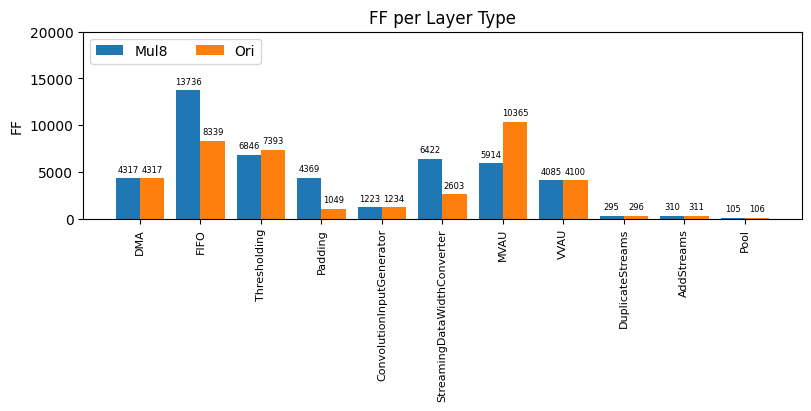

In [27]:
ff_per_layer_type_models = {
    model_1_name: list(ff_per_layer_type_1.values()),
    model_2_name: list(ff_per_layer_type_2.values())
}

x = np.arange(len(ff_per_layer_type_1.keys()))  # the label locations
width = 0.4  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(8, 4))

for attribute, measurement in ff_per_layer_type_models.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3, fontsize = 6)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('FF')
ax.set_title('FF per Layer Type')
ax.set_xticks(x + width/2, ff_per_layer_type_1.keys(), rotation=90, fontsize = 8)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 20000)

plt.show()

## SRL

### SRL Top

In [28]:
sr_top_1 = {k: v['SRL'] for k, v in post_synth_1.items() if k == "(top)"}
sr_top_2 = {k: v['SRL'] for k, v in post_synth_2.items() if k == "(top)"}

print(f'SRL TOP {model_1_name}: {sr_top_1}')
print(f'SRL TOP {model_2_name}: {sr_top_2}')

SRL TOP Mul8: {'(top)': 8515}
SRL TOP Ori: {'(top)': 3681}


### SRL Layer

In [29]:
sr_1 = {k: v['SRL'] for k, v in post_synth_1.items() if k != "(top)"}
sr_2 = {k: v['SRL'] for k, v in post_synth_2.items() if k != "(top)"}
sr_total_1 = list(sr_1.values())
sr_total_2 = list(sr_2.values())

In [30]:
print(f'SRL {model_1_name}: {sum(sr_total_1)}')
print(f'SRL {model_2_name}: {sum(sr_total_2)}')

SRL Mul8: 8302
SRL Ori: 3462


### SRL per Layer Type

In [31]:
sr_per_layer_type_1 = {k: 0 for k in layer_types}
for k, v in post_synth_1.items():
    if k == "(top)":
        print("Top skipped")
    else:
        layer_present = False
        for layer_type in layer_types:
            if layer_type in k:
                layer_present = True
                sr_per_layer_type_1[layer_type] += v["SRL"]
        assert layer_present == True, f'{k} is not present in layer types'

sr_per_layer_type_2 = {k: 0 for k in layer_types}
for k, v in post_synth_2.items():
    if k == "(top)":
        print("Top skipped")
    else:
        layer_present = False
        for layer_type in layer_types:
            if layer_type in k:
                layer_present = True
                sr_per_layer_type_2[layer_type] += v["SRL"]
        assert layer_present == True, f'{k} is not present in layer types'

for (k1, v1), (k2, v2) in zip(sr_per_layer_type_1.items(), sr_per_layer_type_2.items()):
    print(f'{model_1_name}: {k1:<30} = {v1:<6} - {model_2_name}: {k2:<30} = {v2:<6}')

print(f'\nTotal {model_1_name}: {sum(sr_per_layer_type_1.values())}')
print(f'Total {model_2_name}: {sum(sr_per_layer_type_2.values())}')
print(f'Diference {model_1_name}-{model_2_name}: {sum(sr_per_layer_type_1.values()) - sum(sr_per_layer_type_2.values())}')

Top skipped
Top skipped
Mul8: DMA                            = 181    - Ori: DMA                            = 181   
Mul8: FIFO                           = 7748   - Ori: FIFO                           = 2916  
Mul8: Thresholding                   = 373    - Ori: Thresholding                   = 365   
Mul8: Padding                        = 0      - Ori: Padding                        = 0     
Mul8: ConvolutionInputGenerator      = 0      - Ori: ConvolutionInputGenerator      = 0     
Mul8: StreamingDataWidthConverter    = 0      - Ori: StreamingDataWidthConverter    = 0     
Mul8: MVAU                           = 0      - Ori: MVAU                           = 0     
Mul8: VVAU                           = 0      - Ori: VVAU                           = 0     
Mul8: DuplicateStreams               = 0      - Ori: DuplicateStreams               = 0     
Mul8: AddStreams                     = 0      - Ori: AddStreams                     = 0     
Mul8: Pool                           = 0      

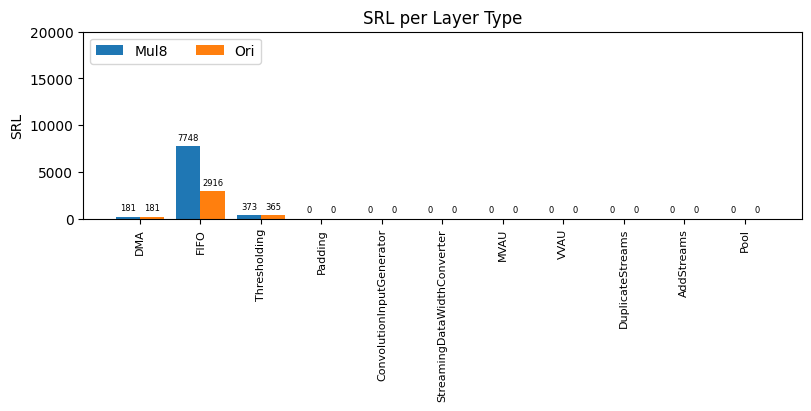

In [32]:
sr_per_layer_type_models = {
    model_1_name: list(sr_per_layer_type_1.values()),
    model_2_name: list(sr_per_layer_type_2.values())
}

x = np.arange(len(sr_per_layer_type_1.keys()))  # the label locations
width = 0.4  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(8, 4))

for attribute, measurement in sr_per_layer_type_models.items():
    osrset = width * multiplier
    rects = ax.bar(x + osrset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3, fontsize = 6)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('SRL')
ax.set_title('SRL per Layer Type')
ax.set_xticks(x + width/2, sr_per_layer_type_1.keys(), rotation=90, fontsize = 8)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 20000)

plt.show()

# FIFO Sizes

In [33]:
fifo_depth_1 = {k: v["depth"] for k, v in final_hw_1.items() if "StreamingFIFO" in k}
fifo_depth_2 = {k: v["depth"] for k, v in final_hw_2.items() if "StreamingFIFO" in k}

Total FIFOs DEPTH used by model Mul8: 78516
Total FIFOs DEPTH used by model Ori: 86744


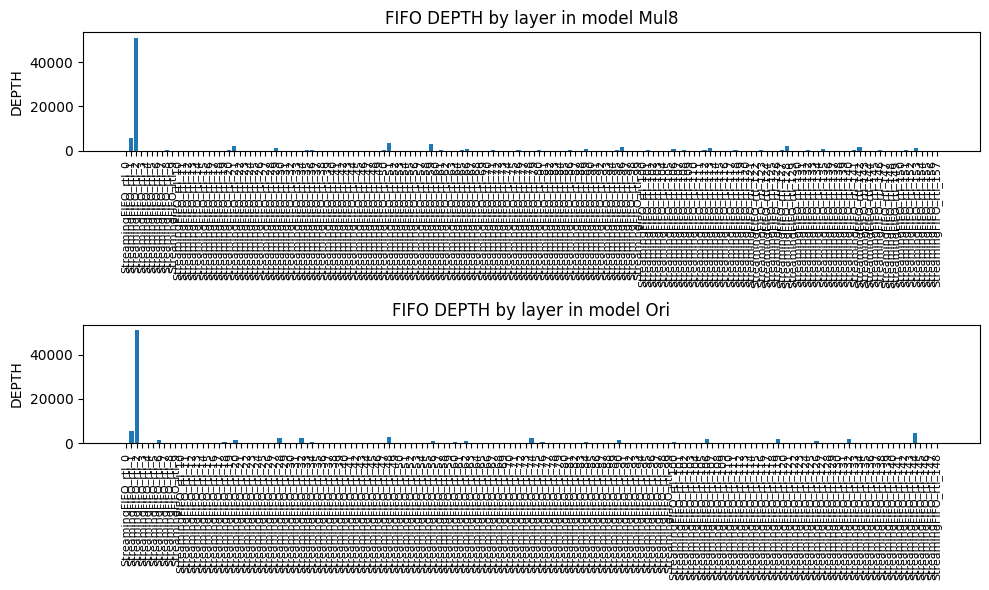

In [39]:
print(f'Total FIFOs DEPTH used by model {model_1_name}: {sum(fifo_depth_1.values())}')
print(f'Total FIFOs DEPTH used by model {model_2_name}: {sum(fifo_depth_2.values())}')

fig, ax = plt.subplots(2, 1, figsize=(10,6))

###########
# MODEL 1 #
###########
layers_name = list(fifo_depth_1.keys())
counts = list(fifo_depth_1.values())

ax[0].bar(layers_name, counts)
ax[0].set_ylabel('DEPTH')
ax[0].set_title(f'FIFO DEPTH by layer in model {model_1_name}')
ax[0].set_xticks(np.arange(len(layers_name)), layers_name, rotation=90, fontsize=8)

###########
# MODEL 2 #
###########
layers_name = list(fifo_depth_2.keys())
counts = list(fifo_depth_2.values())

ax[1].bar(layers_name, counts)
ax[1].set_ylabel('DEPTH')
ax[1].set_title(f'FIFO DEPTH by layer in model {model_2_name}')
ax[1].set_xticks(np.arange(len(layers_name)), layers_name, rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

In [41]:
fifo_depth_2

{'StreamingFIFO_rtl_0': 2,
 'StreamingFIFO_rtl_1': 5472,
 'StreamingFIFO_rtl_2': 51076,
 'StreamingFIFO_rtl_3': 2,
 'StreamingFIFO_rtl_4': 2,
 'StreamingFIFO_rtl_5': 2,
 'StreamingFIFO_rtl_6': 1238,
 'StreamingFIFO_rtl_7': 2,
 'StreamingFIFO_rtl_8': 166,
 'StreamingFIFO_rtl_9': 2,
 'StreamingFIFO_rtl_10': 2,
 'StreamingFIFO_rtl_11': 2,
 'StreamingFIFO_rtl_12': 2,
 'StreamingFIFO_rtl_13': 2,
 'StreamingFIFO_rtl_14': 2,
 'StreamingFIFO_rtl_15': 2,
 'StreamingFIFO_rtl_16': 2,
 'StreamingFIFO_rtl_17': 2,
 'StreamingFIFO_rtl_18': 390,
 'StreamingFIFO_rtl_19': 2,
 'StreamingFIFO_rtl_20': 1394,
 'StreamingFIFO_rtl_21': 2,
 'StreamingFIFO_rtl_22': 2,
 'StreamingFIFO_rtl_23': 2,
 'StreamingFIFO_rtl_24': 2,
 'StreamingFIFO_rtl_25': 2,
 'StreamingFIFO_rtl_26': 2,
 'StreamingFIFO_rtl_27': 2,
 'StreamingFIFO_rtl_28': 2134,
 'StreamingFIFO_rtl_29': 2,
 'StreamingFIFO_rtl_30': 2,
 'StreamingFIFO_rtl_31': 2,
 'StreamingFIFO_rtl_32': 2494,
 'StreamingFIFO_rtl_33': 2,
 'StreamingFIFO_rtl_34': 258,
 'Str